# Word frequency analysis
This notebook conducts word frequency analysis - it tries to identify what words are commonly used by politicians.

Let's first load the data:

In [9]:
import pandas as pd
# load the data
df = pd.read_pickle("../data/binary/us-politicians.pickle")
df.sample(5)

,speaker_id,quote_id,quotation,speaker,party
1437994,212648,2018-05-03-032418,He didn't know the details of this until we kn...,Rudy Giuliani,29468
1043758,6294,2017-09-30-041330,"Julia, you're in our thoughts and our hearts,",Hillary Clinton,29552
137141,76,2017-05-08-081542,"regardless of party, such courage is still pos...",Barack Obama,29552
548689,22686,2018-04-26-138412,These are false accusations. These are false -...,Donald Trump,29468
395686,22686,2017-03-23-160875,We'll see what happens. It's going to be a ver...,Donald Trump,29468


### Preprocessing the quotes
Now, let's define some utility functions that will allow us to apply preprocessing operations such as:
- changing string to lowercase
- removing numbers
- removing punctuation
- removing single characters
- removing leading, trailing and repeating spaces
- expanding contractions
- removing stopwords

In [10]:
import re, string, contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def preprocess_quote(quote):
    # to lowercase
    quote = quote.lower()

    # remove numbers and punctuation
    quote = re.sub(r'\d+', '', quote)
    quote = quote.translate(str.maketrans('', '', string.punctuation))

    # remove all single characters
    quote = re.sub(r'\s+[a-zA-Z]\s+', ' ', quote)
    # Remove single characters from the start
    quote = re.sub(r'\^[a-zA-Z]\s+', ' ', quote)

    # remove leading, trailing, and repeating spaces
    quote = re.sub(' +', ' ', quote)
    quote = quote.strip()

    return quote
    
def fix_contractions(quote, stopwords):
    return contractions.fix(quote)

def remove_words(quote, words):
    tokens = word_tokenize(quote)
    filtered_tokens = [token for token in tokens if token.lower() not in words]
    return " ".join(filtered_tokens)

And now let's apply the preprocessing functions to the data:

In [12]:
# take a sample of the dataset, extract the quotation strings
sample = df.sample(10000)
sample_quotes = sample["quotation"]
sample_quotes.head(5)

1184451    America `s deepening friendship with India is ...
1304249    Who would make the best president at this poin...
1396026    In more than size, he was the largest figure o...
1429796    Paying $130,000 to Stormy whatever, and paying...
1366450    The truth is that trends on the ground -- viol...
Name: quotation, dtype: object

In [15]:
# load the stopwords, and remove them from the quotes
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print("Some stopwords: ", stopwords[:10])
sample_quotes = sample_quotes.apply(lambda quote: remove_stopwords(quote, stopwords))

Some stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [7]:
sample_quotes = sample_quotes.apply(lambda quote: preprocess_quote(quote))
sample_quotes.head(5)

1350994    iran decides break agreement regret breaking p...
713735                        equities basis points two days
53605                          leads us ask might repay debt
665292     thrilled salute prime minister modi indian peo...
618029     million people us figured fake news quite figu...
Name: quotation, dtype: object

In [12]:
tokenized = sample_quotes.apply(lambda quote: word_tokenize(quote))
words = tokenized.explode()
words = words.astype("str")
words.value_counts()

In [4]:
# load the list of most common english words, taken from: https://gist.github.com/deekayen/4148741

def read_most_common(path):
    most_common = []
    with open(path, "r") as file:
        for line in file.readlines():
            most_common.append(line.strip())
    return most_common

most_common = read_most_common("../data/misc/most_common_words_1000.txt")
most_common[:10]

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that']

In [ ]:
# convert words to their stemmed versions
stemmer = PorterStemmer()
most_common_stemmed = [stemmer.stem(word) for word in most_common]
stemmed_words = {x: stemmer.stem(x) for x in (words.unique())}

# and filter out the words w
filtered_words = [word for word in words if stemmed_words[word] not in most_common_stemmed]

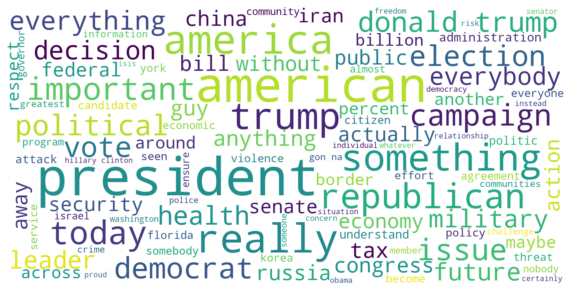

In [32]:
# adapted from: https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

wordcloud = WordCloud(width=1600, height = 800, max_font_size=150, max_words=100, background_color="white")
wordcloud.generate(" ".join(f))

plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()